# ADA final exam (Fall 2024)

This exam consists of 2 tasks. The two tasks are independent of each other. You can solve them in any order.

## Task 1: Natural Language Processing (50 pts)
This part of the exam will analyze a real-world negotiation dataset:

Two participants take the role of campsite neighbors and negotiate for Food, Water, and Firewood packages, based on their individual preferences and requirements. This design keeps the task tractable, while still facilitating linguistically rich and personal conversations.

At the end of each negotiation, both negotiators receive an outcome score (`outcome`) reflecting their success in achieving their goals. The dataset is divided into two data frames:

1. `df_negotiations`, with columns:
    - `negotiation_id`: the negotiation identifier
    - `agent`: the agent active in that turn, either `mt_agent_1` or `mt_agent_2` (first and second to interact)
    - `message`: the message sent to the other agent
    - `turn`: the negotiation turn
2. `df_meta`, meta information for each negotiation with the outcome and agent background:
    - `gender`: (male, female, other)
    - `age`: integer
    - `outcome`: integer

We are interested in finding out: what makes a good (/bad) negotiator?

### Part 1: Coding Questions (29 pt)

In [290]:
import pandas as pd

df_negotiations = pd.read_csv('negotiations.csv')
df_negotiations.head()

,agent,message,negotiation_id,turn
0,mturk_agent_1,Hello! 🙂 Let's work together on a deal for the...,0,0
1,mturk_agent_2,Hey! I'd like some more firewood to keep my do...,0,0
2,mturk_agent_1,I need firewood as well. We have a large group...,0,1
3,mturk_agent_2,I see. 😮 What are you least interested in?,0,1
4,mturk_agent_1,We can make do without extra water. Can we tra...,0,2


In [291]:
df_meta = pd.read_csv('negotiations_meta.csv')
df_meta.head()

,agent,age,gender,negotiation_id,outcome
0,mturk_agent_1,31,female,797,21
1,mturk_agent_2,26,male,797,15
2,mturk_agent_1,65,male,909,18
3,mturk_agent_2,34,female,909,23
4,mturk_agent_1,26,male,135,26


**1.1 (2 pt)**
/Discussion:/ We are interested in analyzing negotiation outcomes by analyzing language usage. In order to use TF-IDF to accomplish this, we will treat all turns from one negotiator in a single negotiation as a "document". Why would this definition of "document" be preferred over the following two alternatives? Give at least one argument per alternative.

- A) Each individual turn is a document
- B) The entire negotiation dialogue of both negotiators is a document

A) We would loose precious contexte information
B) Each negociator has proper language and negociation strategies. By Merging all their sayings, we woul loose information about whether one or the other has better negociation skills, we would loose individuality.

**1.2 (3 pt)**

[A, 1 pt] Use the negotiation dataset to create a new dataframe called `df_document` with the following columns:
- `negotiation_id`
- `agent`
- `document`

Here, document is defined as described in question 1.1. That is: concatonate messages into a single string and split by the special character `"\n"`.

In [292]:
# we need to concatenate all the messages from each turn for each negociation (id) and this for each agent! 
df_document = df_negotiations.groupby(['agent', 'negotiation_id']).agg({'message': '\n'.join}).reset_index()
df_document

,agent,negotiation_id,message
0,mturk_agent_1,0,Hello! 🙂 Let's work together on a deal for the...
1,mturk_agent_1,1,I am good. I am pretty excited for the trip th...
2,mturk_agent_1,2,Hi! How are you?! You excited for your camping...
3,mturk_agent_1,3,"oh dear, I am sorry to hear that my son is typ..."
4,mturk_agent_1,4,"I think food is my highest priority, What abou..."
...,...,...,...
2051,mturk_agent_2,1025,Hello. My friend Jim and bob are on thier way ...
2052,mturk_agent_2,1026,Hello there. Hope you are well today 🙂 \nNot...
2053,mturk_agent_2,1027,"Hello, I'm very excited for my trip, how about..."
2054,mturk_agent_2,1028,"Hey, I am also going camping but I am taking m..."


[B, 2pt] Next, merge this new dataframe with the `df_meta` dataframe. Print the the size and first five rows of the final dataframe

In [293]:
df_merged = df_meta.merge(df_document, on=['negotiation_id', 'agent'])
print(df_merged.shape)
df_merged.head(5)

(2056, 6)


,agent,age,gender,negotiation_id,outcome,message
0,mturk_agent_1,31,female,797,21,Hello. I am also hoping to get extra supplies....
1,mturk_agent_2,26,male,797,15,Hello there! I am looking for extra supplies!🙂...
2,mturk_agent_1,65,male,909,18,hi\nI am. It's really hot here\nHave you given...
3,mturk_agent_2,34,female,909,23,Hello! 🙂 Are you ready to go camping?\nMake su...
4,mturk_agent_1,26,male,135,26,I need to keep the fire burning so i need fire...


**1.3 (7 pt)**
We would like to analyze the difference between "best" and "worst" performers based on `outcome`, top and bottom 10% respectively.

[A, 2 pt] Find the top and bottom 10% thresholds for the `outcome` columns and print them.

In [294]:
print("top 10% threshold:", df_merged["outcome"].quantile(0.9))
print("bottom 10% threshold:", df_merged["outcome"].quantile(0.1))

top 10% threshold: 23.0
bottom 10% threshold: 15.5


[B, 1pt] Create a TF-IDF matrix using the `TfidfVectorizer` form `sklearn`, setting `max_features=100` and `stop_words="english"`. Print the resulting TF-IDF matrix shape.

In [295]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = df_merged['message'].tolist()

vectorizer = TfidfVectorizer(max_features=100, stop_words="english")
tf_idf = vectorizer.fit_transform(corpus)
print(f"The TF-IDF matrix has shape {tf_idf.shape}")

The TF-IDF matrix has shape (2056, 100)


[C, 4pt] Use your thresholds and the TF-IDF matrix to print the top 10 terms for each type of negotiatior (i.e., the best and worst performing negotiators from question 1.3.A).

In [296]:
import numpy as np

idx_top = df_merged.index[df_merged['outcome'] >= df_merged["outcome"].quantile(0.9)].tolist()
tfidf_top = tf_idf[idx_top]
sum_tfidf_top = np.sum(tfidf_top, axis=0)
idx_tf_top = np.argsort(sum_tfidf_top).tolist()[0][:10]
top_words_top = vectorizer.get_feature_names_out()[idx_tf_top]
print("Top 10 words for the best performing negociators:", top_words_top)

idx_bottom = df_merged.index[df_merged["outcome"] <= df_merged["outcome"].quantile(0.1)].tolist()
tfidf_bottom = tf_idf[idx_bottom]
sum_tfidf_bottom = np.sum(tfidf_bottom, axis=0)
idx_tf_bottom = np.argsort(sum_tfidf_bottom).tolist()[0][:10]
top_words_bottom = vectorizer.get_feature_names_out()[idx_tf_bottom]
print("Top 10 words for the worst performing negociators:", top_words_bottom)

Top 10 words for the best performing negociators: ['additional' 'people' 'pretty' 'thinking' 'feel' 'rest' 'away' 'item'
 'fun' 'firewoods']
Top 10 words for the worst performing negociators: ['split' 'priority' 'love' 'stay' 'item' 'works' 'pretty' 'way' 'does'
 'having']


**1.4 (8 pt)**
You never get a second chance at a first impression! Let's investigate if the same goes for negotiations...

[A, 1pt] Create a new df_document that only takes into account the first three (3) turns of each negotiator in a negotiation. Again, merge on the df_meta dataframe and print the resulting size.

In [297]:
df_negotiations_trunc = df_negotiations[df_negotiations['turn'] <= 3]
df_document = df_negotiations_trunc.groupby(['agent', 'negotiation_id']).agg({'message': '\n'.join}).reset_index()
df_merged = df_meta.merge(df_document, on=['negotiation_id', 'agent'])
print(df_merged.shape)
df_merged.head(5)

(2056, 6)


,agent,age,gender,negotiation_id,outcome,message
0,mturk_agent_1,31,female,797,21,Hello. I am also hoping to get extra supplies....
1,mturk_agent_2,26,male,797,15,Hello there! I am looking for extra supplies!🙂...
2,mturk_agent_1,65,male,909,18,hi\nI am. It's really hot here\nHave you given...
3,mturk_agent_2,34,female,909,23,Hello! 🙂 Are you ready to go camping?\nMake su...
4,mturk_agent_1,26,male,135,26,I need to keep the fire burning so i need fire...


[B, 1pt] Calculate the median negotiation outcome. Then, add a column called success to the df_document dataframe that is 1 if the outcome column is more than the median and 0 otherwise. Print the median outcome.

In [298]:
median = df_merged['outcome'].median()
print("median negociation outcome:", median)

df_document['success'] = df_merged['outcome'].apply(lambda x: 1 if x > median else 0)
df_document.head()

median negociation outcome: 19.0


,agent,negotiation_id,message,success
0,mturk_agent_1,0,Hello! 🙂 Let's work together on a deal for the...,1
1,mturk_agent_1,1,I am good. I am pretty excited for the trip th...,0
2,mturk_agent_1,2,Hi! How are you?! You excited for your camping...,0
3,mturk_agent_1,3,"oh dear, I am sorry to hear that my son is typ...",1
4,mturk_agent_1,4,"I think food is my highest priority, What abou...",1


[C, 2pt] Create a TF-IDF matrix called `X` based on `df_document` using the following settings:

`max_features=100, stop_words="english, ngram_range=(1, 2)`

Additionally, create a variable `y` that corresponds to the success column. Finally, use `sklearn.model_selection.train_test_split` to split your data into a train and test set using parameters `test_size=0.2` and `random_state=99`.

Print the shape of the TF-IDF and the shape of your train and test sets.

In [299]:
corpus = df_document['message'].tolist()

vectorizer = TfidfVectorizer(max_features=100, stop_words="english", ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus)
print(f"The TF-IDF matrix has shape {X.shape}")

y = df_document['success']

The TF-IDF matrix has shape (2056, 100)


In [300]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape} and y_test: {y_test.shape}")

X_train: (1644, 100), X_test: (412, 100), y_train: (1644,) and y_test: (412,)


[D, 2pt] Use your prepared data to train a logistic regression model (`sklearn.linear_model.LogisticRegression`). Then, with the trained model predict on the test set and print a classification report (`sklearn.metrics.classification_report`).

In [301]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

clf = LogisticRegression()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.634     0.915     0.749       258
           1      0.450     0.117     0.186       154

    accuracy                          0.617       412
   macro avg      0.542     0.516     0.467       412
weighted avg      0.565     0.617     0.539       412



[E, 2pt] Use the weights of your trained model to show which terms mostly strongly correlate with high and low outcomes. Print the best five terms for each.

In [302]:
print(f"we have {clf.coef_.shape[1]} weights")

idx_top = np.argsort(clf.coef_).tolist()[0][:10]
coefs_high = vectorizer.get_feature_names_out()[idx_top]
print("Terms for high outcome (1, good negociation)", coefs_high)

idx_bottom = np.argsort(clf.coef_).tolist()[0][-10:]
coefs_low = vectorizer.get_feature_names_out()[idx_bottom]
print("Terms for low outcome (0, good negociation)", coefs_low)

we have 100 weights
Terms for high outcome (1, good negociation) ['item' 'waters' 'pack' 'items' 'packages water' 'work' 'family'
 'need firewood' 'lot' 'need']
Terms for low outcome (0, good negociation) ['food' 'want' 'warm' 'yes' 'definitely' 'water food' 'really' 'hope'
 'extra water' 'way']


**1.5 (9 pt)**
You are concerned about potential “confounding” factors for your results in the previous question. Specifically, you would like to investigate the effect of “gender” on the outcomes.

[A, 3pt] Visualize the outcomes stratified by gender using a bar plot with standard deviation around the mean. Make sure you use clear x- and y-axis labels, a title, and a legend.

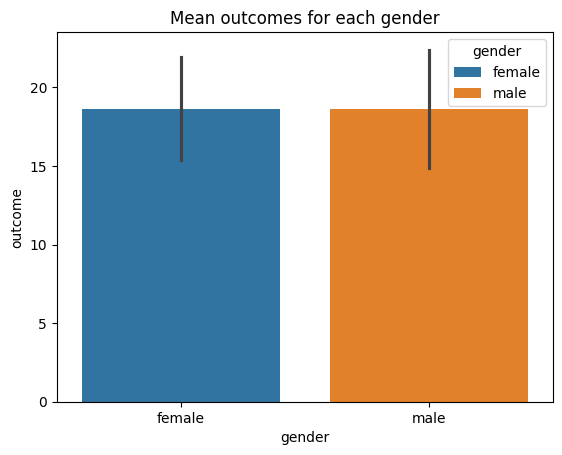

In [303]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x="gender", y="outcome", hue='gender', data=df_merged[['gender', 'outcome']], errorbar="sd", legend=True)
plt.ylabel("outcome")
plt.title("Mean outcomes for each gender")
plt.show()

[B, 2pt] Perform a T-Test with a confidence interval of 0.95 to check if the outcomes based on gender are statistically significantly different. Print the resulting t-statistic, the p-value, and your interpretation of the result.

In [304]:
from scipy import stats

stats.ttest_ind(df_merged[df_merged['gender'] == 'male']['outcome'], df_merged[df_merged['gender'] == 'female']['outcome'])

TtestResult(statistic=-0.1518207180233982, pvalue=0.8793432508556187, df=2054.0)

The NULL in this test is that the 2 samples have identical average

- p-value = 0.88 > 0.05 which means that the NULL cannot be rejected, so we can say that the outcomes for men and women are not statistically significantly different. 

[C, 2pt] Finally, we would like to test if the gender distribution between high and low negotiation performers is significantly different. Please perform a chi-square test on the gender distribution of those negotiators scoring above the median outcome. Use a confidence interval of 0.95 and print the resulting chi-square statistic, p-value, and your interpretation of the result.

In [305]:
from scipy.stats import chisquare

chisquare(df_merged[df_merged['outcome'] > median]['gender'])

ValueError: could not convert string to float: 'female'

[D, 2pt] /Discuss:/ In addition to the gender attribute, could you think of other measurable factors in this dataset that could be tested as confounders? List at least two more and explain why.

Another confounder would be the message length. It could be that negociators that perform better simply are more persistant and speak more and longer. 

### Part 2: Insight Questions (15 pt)

**2.1 (3pt)**
In the context of analyzing negotiation turns, why would TF-IDF be more suitable than simple word frequency counts when trying to identify distinctive communication patterns between successful and unsuccessful negotiations?

In a TF-IDF, weights of words depend on the rest of the corpus and not simply on the document being considered. In our context of negociation, we want to capture cross-negiciation word importance and not only the words that are important in a particular negociation session. 

**2.2 (2pt)**
How would you modify the standard TF-IDF implementation to account for the temporal nature of negotiation turns? Consider that early turns might be more important for setting the tone of the negotiation than later turns.

I would give larger weights to words occuring later in the negociation since negociation is more intense and important later in the conversation. Smaller weights would be attributed to words appearing earlier in the conversation. Simply said, I would mutliply, for each document/negociation, each term in the TD-IDF matri by a temporla weight that is as described above. 

**2.3 (3 pt)**
In our negotiation dataset, successful negotiators might simply write longer messages. How could this create a misleading interpretation of our TF-IDF results, and what would be a simple way to test for this potential bias?

Longer messages have more words in them, making our interpretation of the TF-IDF misleading. We could control for the length confounder by normalizing each valueof the TF-IDF by the length of the message (so rowwise normalization)

**2.4 (3pt)**
In our negotiation dataset, consider these two opening messages from different agents:

Agent A: "I propose we split the resources fairly" Agent B: "I suggest we divide the assets equitably"

These messages are semantically very similar but use different vocabulary. Explain:

- a) How TF-IDF would process these messages differently
- b) How word embeddings (like Word2Vec) would handle them
- c) Why this distinction matters for negotiation analysis

[your answer]

**2.5 (4pt)**
Staying in the context of negotiations, explain why N-gram models such as bigrams might be more informative than unigrams for predicting negotiation outcomes. Provide two examples of bigrams that would be particularly meaningful in negotiation contexts but would lose their significance if split into unigrams.

A same word might not lead to same outcome when placed in different contexts: 

- lower prices 
- 

## Task 2: Analysis of Co-Author Network (50 pts)


In this part, you will analyze a reserach publication dataset derived from 
[social influence analysis in large-scale networks](https://keg.cs.tsinghua.edu.cn/jietang/publications/KDD09-Tang-et-al-Social-Influence-Analysis.pdf) (the paper itself is irrelevant to this exam, don't waste time reading it).

The citation data is extracted from DBLP, ACM, MAG (Microsoft Academic Graph), and other sources. Each paper is associated with abstract, authors, year, venue, and title.

Dataset: [citation dataset](https://cn.aminer.org/citation)

Paper: [social influence analysis in large-scale networks](https://keg.cs.tsinghua.edu.cn/jietang/publications/KDD09-Tang-et-al-Social-Influence-Analysis.pdf)


### Download data from the web

#### For Linux and MacOS:
```bash
wget https://lfs.aminer.cn/lab-datasets/citation/citation-network1.zip
unzip citation-network1.zip
ls -l outputacm.txt
```

#### For windows we recommend using WSL (Windows Subsystem for Linux) with above commands or directly downloading the file from the browser at 
https://lfs.aminer.cn/lab-datasets/citation



In [306]:
import numpy as np
import pandas as pd
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt

from helper import load_data_as_df


# Define the file path
file_path = "outputacm.txt"

# Load the data into a DataFrame
df = load_data_as_df(file_path)

# check if the index column is the same as the index 
print(f"Dataset loaded with {len(df)} entries.")
print(f"colums: {df.columns}")

Dataset loaded with 629814 entries.
colums: Index(['title', 'authors', 'year', 'venue', 'references', 'abstract'], dtype='object')


**3.1 (6 pts)**: Analyze Papers Published Per Year

**Objective:**  
Analyze and visualize publication trends to understand how the research field has evolved over time.

#### Instructions:
1. Group the data by the year of publication and count the number of papers for each year (2 pts).
2. Plot a bar chart showing the number of papers published per year from **1990 to 2010**. (2 pts)
3. Focus on the pattern between **1996 and 2004**:
   - **Discuss:** Describe any notable trends or changes in the number of publications during this period. (2 pts)
   - **Bonus:** Hypothesize potential reasons for the observed pattern.  (2 pts)
     *Hint: Consider events or trends related to the dataset's focus on computer science.* 


In [307]:
# 1
df_year = df.groupby('year').size().reset_index(name='papers')

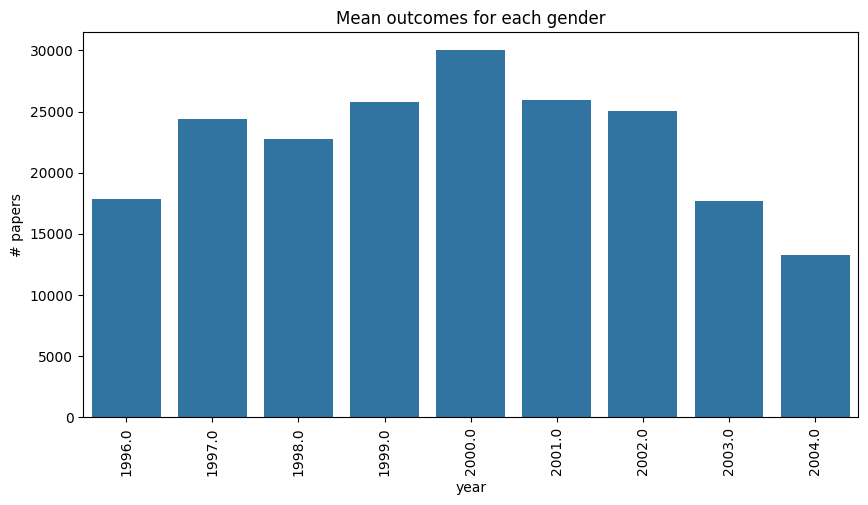

In [308]:
# 2
plt.figure(figsize=(10, 5))
sns.barplot(x="year", y="papers", data=df_year[(df_year['year'] >= 1996) & (df_year['year'] <= 2004)])
plt.ylabel("# papers")
plt.xticks(rotation=90)
plt.title("Mean outcomes for each gender")
plt.show()

3) We note a glabally increasing trend between 1996 and 2000 and then decreasing. In 2000 there is a peak, surely because of the computer being developped!

**3.2 (4 pts)**: Authors Per Paper Analysis

With the rise of interdisciplinary research, multi-authored papers are becoming more common. This task will help us understand collaboration dynamics in the academic world.

#### Instructions:
- Get the number of authors for each paper and calculate the percentage of papers with four or more authors. (2 pts)
- Plot a histogram to show the frequency distribution of the number of authors per paper (2 pts)(choose `bins=range(0, 30)` and set y-axis to log scale).

Percentage of paper with 4 or more authors: 13%


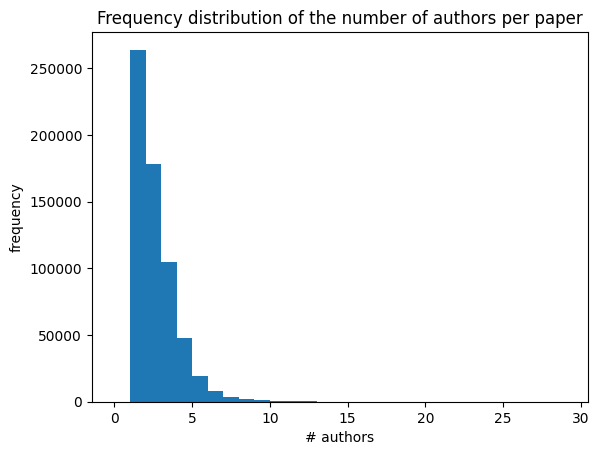

In [309]:
df_authors = df[['title', 'authors']]
df_authors.loc[:, 'authors'] = df_authors['authors'].apply(lambda x: len(x))

print(f"Percentage of paper with 4 or more authors: {round(len(df_authors[df_authors['authors'] >= 4]) / len(df_authors) * 100)}%")

plt.hist(df_authors['authors'], bins=range(0, 30))
plt.xlabel("# authors")
plt.ylabel("frequency")
plt.title("Frequency distribution of the number of authors per paper")
plt.show()

**3.3 (4 pts)**: Temporal Collaboration Trends

Collaboration dynamics can change over time. This task will help us understand how collaboration trends have evolved in the academic world.

#### Instructions:
- Group the data by publication year, calculate the average number of authors per paper for each year, and create a line plot to visualize how it has changed from 1990 to 2010 (1 pt).
- **Discuss:** There has been a hypothesis that the number of authors per paper has increased over time. Based on the plot, do you agree with this hypothesis ? (1 pt)
- Compute the P-value of the hypothesis that the average number of authors per paper after 2000 is significantly higher than before 2000. (2 pts)

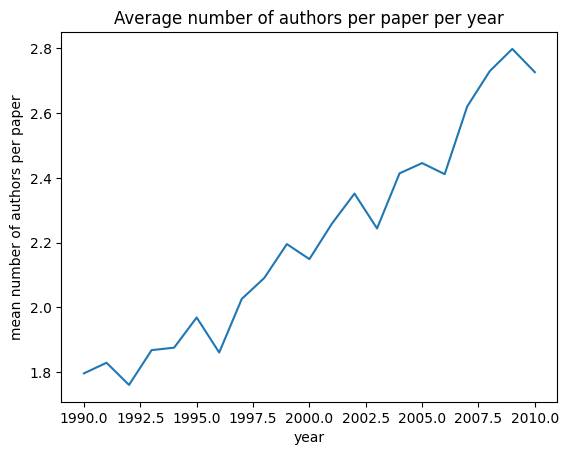

In [310]:
df['num_authors'] = df_authors['authors']

df_year_authors = df.groupby('year').agg({'num_authors': 'mean'}).reset_index()

plt.plot(df_year_authors[(df_year_authors['year'] >= 1990) & (df_year_authors['year'] <= 2010)]['year'], df_year_authors[(df_year_authors['year'] >= 1990) & (df_year_authors['year'] <= 2010)]['num_authors'])
plt.xlabel('year')
plt.ylabel('mean number of authors per paper')
plt.title("Average number of authors per paper per year")
plt.show()

- The average number of authors per paper clearly increases every year. The hypothesis is true :) Carefull that this plot shows the average number of authors, is might be that some papers have an insanely high number of authors and some have only one author. But clearly, the MEAN number of authors increases!

In [311]:
df_year_authors[df_year_authors['year'] > 2000]['num_authors']

55    2.258768
56    2.351465
57    2.243817
58    2.414071
59    2.445662
60    2.411473
61    2.620667
62    2.729605
63    2.798189
64    2.726316
65         1.0
Name: num_authors, dtype: object

In [312]:
stats.ttest_ind(df_year_authors[df_year_authors['year'] > 2000]['num_authors'], df_year_authors[df_year_authors['year'] < 2000]['num_authors'], alternative='greater')

ValueError: data type <class 'numpy.object_'> not inexact

**3.4 (6 pts)**: Build a Co-Author Network

Co-author networks help us visualize and quantify collaborations in academia. Such networks are critical for identifying influential researchers and their role in fostering connections within their communities. Construct a network where nodes represent authors and edges represent collaborations.

#### Instructions:
- Create a graph where: (5 pts)
  - Nodes: Each node represents a unique author, identified by their name in the authors field of the dataset.
  - Edges: There is an edge between two nodes if the corresponding authors have co-authored at least one paper. The weight of the edge represents the number of papers the two authors have co-authored together.
- After constructing the network, print the following information: (1 pt)
  - The total number of nodes (authors) in the network.
  - The total number of edges (collaborations) in the network.

Example:

For a paper authored by ["Alice", "Bob", "Charlie"], the graph should include:
- Nodes: Alice, Bob, Charlie.
- Edges: Alice-Bob, Alice-Charlie, Bob-Charlie, each with a weight of 1 (assuming no other collaborations between these pairs).


In [313]:
import itertools
from collections import Counter
from tqdm import tqdm

co_occurrences = []
for el in df['authors']:
    co_occurrences.append(list(itertools.combinations(el, 2)))

co_occurrences = list(itertools.chain(*co_occurrences))
count_co_occurrences = dict(Counter(co_occurrences))
count_co_occurrences

graph_constr = [(k[0], k[1], v) for k, v in count_co_occurrences.items()]

G1 = nx.Graph()
G1.add_weighted_edges_from(graph_constr, weight='weight')

print(G1)

Graph with 505027 nodes and 1137185 edges


**3.5 (4 pts)**: Analyze the Co-Author Network

Connected components in a co-author network can reveal isolated research communities or dominant research hubs. Analyzing the largest component helps us understand the core of academic collaboration

#### Instructions:
- The degree of a node is the number of edges connected to it. In the context of the co-author network, this represents the number of distinct co-authors an author has collaborated with. Compute the average degree of the network (1 pt).
- Connectivity of the Network:
  - A network is fully connected if there is a path between every pair of nodes. Determine if the co-author network is fully connected (2 pt). (Hint: A single answer is not enough here. You need to use a method to verify the connectivity of the network.)
  - Can you tell how many authors are part of the largest connected component? How much does this account for the total number of authors in the network? (2 pt)
<!-- - Compute the average clustering coefficient of the network. -->

In [314]:
avg_degree = G1.number_of_edges() / G1.number_of_nodes()
print(f"{round(avg_degree, 2)} average node degree")

2.25 average node degree


In [315]:
def describe_graph(G):
    print(G)
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

describe_graph(G1)

Graph with 505027 nodes and 1137185 edges
Graph is not connected
Diameter and Avg shortest path length are not defined!
Sparsity: 0.0000
Global clustering coefficient aka Transitivity: 0.1422


We see that the the network is not connected. Indeed, the diameter (i.e. longest shortest path) and shortest path length are not defined!

In [316]:
largest_cc = max(nx.connected_components(G1), key=len) # take longest weakly connected component! 
H = G1.subgraph(largest_cc)
print(f"# nodes in largest connected component: {H.number_of_nodes()}")
print(f"--> this represents {round(H.number_of_nodes() / G1.number_of_nodes() * 100)}% of all authors in the network")
print(f"# nodes in largest connected component: {H.number_of_edges()}")

# nodes in largest connected component: 342738
--> this represents 68% of all authors in the network
# nodes in largest connected component: 948805


**3.6 (4 pts)**: Top Authors by Collaborations

#### Instructions:
- Get the degree for all nodes in the network and print the top 10 authors by degree (1 pt) (Note: some entries (e.g., "II," "III," "Jr.") may not represent real authors due to data quality issues. Please keep them in the list and don't do any cleaning.)
- A high degree  indicates that an author has collaborated with many other authors. However, it does not consider if the collaborations happen multiple times between the same authors. A weighted degree would be a better measure to consider the number of collaborations between authors. Get the top 10 authors by weighted degree. P.S. The weighted degree is the sum of the weights of the edges connected to the node. (1 pt)
- Which two authors have the highest number of collaborations? How many papers have they co-authored together? (2 pt)

In [317]:
degrees = dict(G1.degree())
sorted_degrees = sorted(degrees.items(), key=lambda x:x[1], reverse=True)

top_authors = sorted_degrees[:10]
print("Top 10 authors by degree:")
[top_authors[i][0] for i in range(len(top_authors))]

Top 10 authors by degree:


[' Jr.',
 ' III',
 ' II',
 'Wei Wang',
 'Ming Li',
 'Wei Li',
 'Lei Zhang',
 'Elisa Bertino',
 'Hector Garcia-Molina',
 'Yan Zhang']

In [318]:
degrees = dict(G1.degree(weight='weight'))
sorted_degrees = sorted(degrees.items(), key=lambda x:x[1], reverse=True)

top_authors = sorted_degrees[:10]
print("Top 10 authors by degree:")
[top_authors[i][0] for i in range(len(top_authors))]

Top 10 authors by degree:


[' Jr.',
 ' III',
 ' II',
 'Wei Wang',
 'Philip S. Yu',
 'Elisa Bertino',
 'Ming Li',
 'Hector Garcia-Molina',
 'Ben Shneiderman',
 'Ron Kikinis']

In [319]:
most_colabs = sorted(count_co_occurrences.items(), key=lambda x:x[1], reverse=True)[0]
most_colabs

(('Gary B. Shelly', 'Thomas J. Cashman'), 154)

**3.7 (4 pts)**: Analyze the reference/citation information 

Understanding the citation patterns of papers helps reveal their academic impact and how knowledge propagates through the research community. In this task, you will analyze the reference and citation relationships within the dataset.

First, let's create a citation network where:
- Nodes: Each node represents a unique paper, identified by its id in the dataset.
- Edges: There is an edge from paper A to paper B if paper A cites paper B. 


#### Instructions:
- **Discuss:** Is it reasonable that the citation network contains cycles?  What would a cycle( not self loop) in the citation network represent? (2 pt)
- Which paper has the highest number of citations? How many papers cite this paper? (1 pt)
- Which paper has the highest number of references? How many papers does this paper cite? (1 pt)


In [320]:
idx_to_paper = {}
for el in df.index:
    idx_to_paper[el] = df.loc[el, 'title']
idx_to_paper

{0: 'Automated Deduction in Geometry: 5th International Workshop, ADG 2004, Gainesville, FL, USA, September 16-18, 2004, Revised Papers (Lecture Notes in Computer ... / Lecture Notes in Artificial Intelligence)',
 1: 'A+ Certification Core Hardware (Text & Lab Manual)',
 2: 'Performance engineering in industry: current practices and adoption challenges',
 3: 'Dude, You Can Do It! How to Build a Sweeet PC',
 4: 'What Every Programmer Needs to Know about Security (Advances in Information Security)',
 5: 'Interpreting Kullback-Leibler divergence with the Neyman-Pearson lemma',
 6: 'Digital Media: Transformations in Human Communication',
 7: 'TOPP---the OpenMS proteomics pipeline',
 8: 'Type Graphics and MacIntosh',
 9: 'Adaptive Hypermedia and Adaptive Web-Based Systems: 4th International Conference, AH 2006, Dublin, Ireland, June 21-23, 2006, Proceedings (Lecture Notes in Computer Science)',
 10: 'Dependable Computing: Second Latin-American Symposium, LADC 2005, Salvador, Brazil, October

In [321]:
G2 = nx.DiGraph()
G2.add_nodes_from(idx_to_paper.keys())

for i in range(len(df)):
    references = df.loc[i, 'references']
    for ref in references:
        G2.add_edge(i, idx_to_paper[ref])
print(G2)

DiGraph with 776686 nodes and 632458 edges


- Cycles mean that a paper references another paper that referenced it! So basically, if I publish a paper, I would reference a paper that references my paper!! This is not of good scientifique practice and should not happen.

In [322]:
degrees_in = dict(G2.in_degree())
most_citations = sorted(degrees_in.items(), key=lambda x:x[1], reverse=True)[0]
print("Most cited:", most_citations)

Most cited: ('Introduction to algorithms', 816)


In [323]:
degrees_out = dict(G2.out_degree())
most_references = sorted(degrees_out.items(), key=lambda x:x[1], reverse=True)[0]
print("Most references:", most_references)
print("paper: ", idx_to_paper[216749])

Most references: (216749, 195)
paper:  Query evaluation techniques for large databases


**3.8 (3 pts)**: Analyze the Citation Distribution 

The citation distribution of papers can provide insights into the impact of research publications. In this task, you will analyze the citation distribution in the dataset.

<!-- - Plot the number of papers having a certain level of citation x (x-axis) against x (y-axis) in a log-log scale. -->
- Create a frequency distribution where the x-axis represents the number of citations and the y-axis represents the number of papers that have that number of citations. Plot two scatters plot of the frequency distribution first in a normal scale and second in a log-log scale. (2 pts)
- **Discuss**: What does the plot suggest about the citation distribution in the dataset? (1 pt)

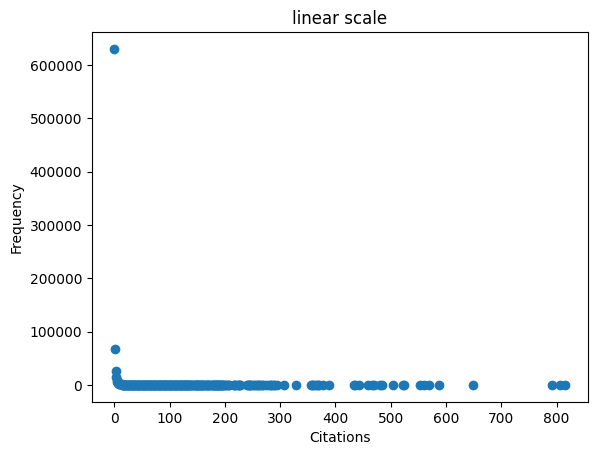

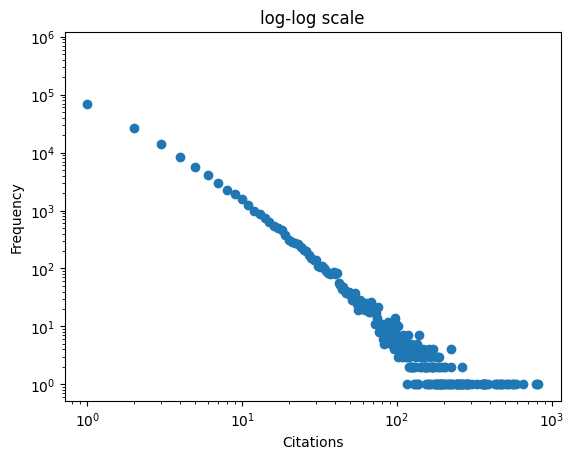

In [324]:
count = dict(Counter(degrees_in.values()))
plt.scatter(count.keys(), count.values())
plt.xlabel("Citations")
plt.ylabel("Frequency")
plt.title("linear scale")
plt.show()

plt.scatter(count.keys(), count.values())
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Citations")
plt.ylabel("Frequency")
plt.title("log-log scale")

plt.show()

The citation distribution is a powr law. It means that most paper are cited few times and few paper are cited many times :))

**3.9 (3 pts)**: Central Tendency of Citation Distribution

**Discuss:**: There are different ways to describe the central tendency of a citation distribution., such as mean. Determine the measure you think best represents the dataset and explain your reasoning. (Hint: Consider the distribution of the citation data above)


For this dataset it is best to use the median, since we oberserve a power law. For a power law, the mean is not representative and the median is better suited!! The mean is sensitive to outliers and the power law is constituted of many outliers!! The median is more robust to outliers :)

**3.10 (2pts)**: Network Centrality Measures

PageRank is a measure of influence based on link structure. Applying it to citations allows us to rank papers by their academic importance

#### Instructions:
- You are tasked with curating the 'Top 10 Influential Papers' from this dataset. Use PageRank to justify your selection and display the top 10 papers titles by page rank. (2 pts)
- **bonus**: Identify patterns among the top-ranked papers. (2 pts)


In [325]:
pagerank = dict(nx.pagerank(G2))

**3.11 (5 pts)**: Bridge Papers

Bridge papers are those that connect different research communities. They are essential for fostering interdisciplinary research and knowledge transfer. 

#### Instructions: 
- Build a small citation network that only includes papers published in 2005. (2 pts)
- Which measurement can help us identify bridge papers in a citation network?  (2 pt)
- Try to find top10 bridge papers in the dataset. By looking at their titles, can you identify the research communities they connect? (Pick 2 papers) (1 pt)



In [326]:
# TODO

**3.12 (5 pts)**: Author-Citation Network

In the previous tasks, we analyzed the co-author network and paper-citation network. In this task, we will analyze the author-citation network, where:
- Nodes: Each node represents a unique author, identified by their name in the authors field of the dataset.
- Edges: There is an edge from author A to author B if author A cites a paper authored by author B. 
- The weight of the edge represents the total number of citations from author A to author B.

#### Instructions:
- Given that we have a Author-Paper Matrix $A$ where each row represents an paper and each column represents an author. The value in the matrix is 1 if the author has contributed to the paper, 0 otherwise. And we also have a Paper-Paper citation matrix $P$ (square matrix) where the value at coordinates (i, j) is 1 if paper j cites paper i, 0 otherwise.
- How can you get a Author-Author citation matrix from the above two matrices by matrix multiplication? (You don't need to implement this, just give the formula) (2 pts)
- Author A may have never cited author B, but author A might have cited a few papers which cited works by author B. This can be seen as a 2nd degree citation.  More formally, a 2nd degree citation matrix $C_2$ has at each cell (i, j) the number 2nd degree citations from author i to author j. How can you get a 2nd degree citation matrix from the Author-Paper Matrix $A$ and Paper-Paper citation matrix $P$? (You don't need to implement this, just give the formula) (2 pts)
- Can you generalize this to nth degree citation matrix? (1 pt)

In [327]:
# TODO